# Close mappings

- Plot histogram of lengths between close queries
- Get list of close queries with 2 mappings
- Get list of close queries with 3+ mappings
- Write fasta with query subsequences between reverse duplications

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import gzip

In [2]:
csv_all = "../results/2022-09-21_amoxicillin_run_vial_14_time_14/suppl_reads_info.csv"
df_all = pd.read_csv(csv_all)
df_all.sort_values(by="query_name")

,Unnamed: 0,query_name,is_forward,type,ref_start,ref_end,query_start,query_end,alignment_length,query_length,matches,insertions,deletions,soft_clips,hard_clips
399,399,0009d992-238c-41a6-a605-38142f57f905,False,supplementary,3762596,3770895,27876,21537,6339,28947,6166,173,2133,0,22608
398,398,0009d992-238c-41a6-a605-38142f57f905,True,primary,3749250,3770890,67,21526,21459,28947,21198,261,442,7488,0
302,302,007490db-1831-4d4b-9186-941351e0a478,False,supplementary,2675345,2676671,4290,2959,1331,4294,1315,16,11,0,2963
268,268,007490db-1831-4d4b-9186-941351e0a478,True,primary,2671856,2674853,0,2980,2980,4294,2957,23,40,1314,0
563,563,043c0bbc-6155-480c-9aa9-1dbb5e473788,True,supplementary,4527351,4530164,10445,12650,2205,12727,2157,48,656,0,10522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,fcc65a75-068b-4246-8117-23545e299812,False,primary,594836,617527,22573,0,22573,28699,22346,227,345,6126,0
71,71,fd1d4edc-6800-4ab9-b96c-4142c684d8f3,True,primary,167778,205694,6704,43309,36605,43309,36159,446,1757,6704,0
70,70,fd1d4edc-6800-4ab9-b96c-4142c684d8f3,False,supplementary,167693,174262,6506,0,6506,43309,6429,77,140,0,36803
132,132,fee128f8-de52-4e23-be1b-70112ad38718,True,primary,775190,804965,54,29605,29551,36040,29248,303,527,6489,0


In [3]:
def remove_queries_with_secondary(query_names, df):
    '''
    Remove queries with secondary mappings from a list of query names.
    '''
    for row in df.itertuples():
        if row.type == "secondary":
            query_names = query_names[query_names != row.query_name]
    return query_names

In [4]:
def remove_queries(query_names, df, to_remove):
    '''
    Remove specified queries and those with > 2 mappings from a list of query names.
    '''
    for name in query_names:
        if name in to_remove:
            query_names = query_names[query_names != name]
            continue
        count = 0
        for row in df.itertuples():
            if row.query_name == name:
                count += 1
        if count > 2:
            query_names = query_names[query_names != name]
    return query_names

In [5]:
def extract_query_names(csv_file):
    '''
    Extract list of query names from csv file.
    '''
    df = pd.read_csv(csv_file)
    names = []
    for q in df.itertuples():
        names.append(q.query_name)
    return names

In [6]:
# Create list of diagonal/close queries with one primary and one supplementary mapping
distant_queries = extract_query_names("../results/2022-09-21_amoxicillin_run_vial_14_time_14/distant_mappings.csv")
query_names = np.unique(df_all["query_name"])
query_names = remove_queries(query_names, df_all, distant_queries)

In [7]:
def get_distances(query_names, df):
    '''
    Get list of distances between mappings of the same query.
    Negative distances indicate an overlap between mappings.
    '''
    neg_dist = []
    distances = []
    for name in query_names:
        start = []
        end = []
        for row in df_all.itertuples():
            if row.query_name == name:
                start.append(row.ref_start)
                end.append(row.ref_end)
        dist = np.max(start)-np.min(end)
        distances.append(dist)
        if dist < 0:
            neg_dist.append(name)
    print(len(neg_dist)) # Print number of negative distances
    return np.array(distances)

41


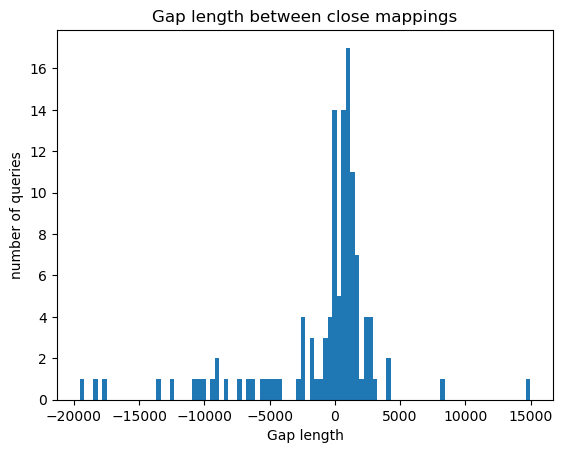

In [8]:
# Plot histogram of lengths
distances = get_distances(query_names, df_all)
plt.hist(distances[(distances > -20000) & (distances < 20000)], bins = 100)
plt.title("Gap length between close mappings")
plt.xlabel("Gap length")
plt.ylabel("number of queries")
plt.show()

## More than 2 close mappings

In [9]:
def remove_under_3_mappings(query_names, df, to_remove):
    '''
    Remove specified queries and those with < 3 mappings from a list of query names.
    '''
    for name in query_names:
        if name in to_remove:
            query_names = query_names[query_names != name]
            continue
        count = 0
        for row in df.itertuples():
            if row.query_name == name:
                count += 1
        if count < 3:
            query_names = query_names[query_names != name]
    return query_names

In [10]:
# Create list of queries with more than 2 mappings on the diagonal
names = np.unique(df_all["query_name"])
names = remove_under_3_mappings(names, df_all, distant_queries)

## Reverse duplications

In [11]:
def reverse_duplications(query_names, df):
    '''
    Get a dictionary for query subsequences between reverse duplications.
    '''
    rev_dupl = []
    for name in query_names:
        ref_start = []
        ref_end = []
        query_start = []
        query_end = []
        for row in df_all.itertuples():
            if row.query_name == name:
                # get reference position
                ref_start.append(row.ref_start)
                ref_end.append(row.ref_end)
                # get query position
                if row.is_forward:
                    query_start.append(row.query_start)
                    query_end.append(row.query_end)
                else:
                    query_end.append(row.query_start)
                    query_start.append(row.query_end)
        dist = np.max(ref_start) - np.min(ref_end)
        if dist < 0: # is reverse duplication
            rev_dupl.append({
                "query_name" : name,
                "gap_start" : np.min(query_end),
                "gap_end" : np.max(query_start),
                "ref_distance" : dist
            })
    return rev_dupl


In [12]:
def write_query_subsequences_to_fasta(input_file, output_file, query_list):
    '''
    Write subsequences of a list of queries to a fasta file.
    '''
    records = []
    for record in SeqIO.parse(gzip.open(input_file, "rt"),"fastq"):
        for query in query_list:
            if record.id == query["query_name"]:
                records.append(SeqRecord(record.seq[query["gap_start"]:query["gap_end"]],
                "{0}_{1}_{2}".format(query["query_name"], query["gap_start"], query["gap_end"]), "", ""))
    SeqIO.write(records, output_file, "fasta")

In [13]:
# Query subsequence between reads for reverse duplications
rev_dupl = reverse_duplications(query_names, df_all)

# Extract subsequences from fastq file
input_file = "../data/2022-09-21_amoxicillin_run_vial_14_time_14/reads.fastq.gz"
output_file = "../results/2022-09-21_amoxicillin_run_vial_14_time_14/reverse_duplications_gap_seqs.fa"
write_query_subsequences_to_fasta(input_file, output_file, rev_dupl)